# Investor Sentiment and the Cross-Section of Stock Returns

*Author: Dacian Peng (彭德鑫), collaborator: @github.com/ppoak*

*Scripted in: 2022-07*

Data source: *Choice Financial Terminal, Wind Financial Terminal*


Reference:

BAKER, M. and J. WURGLER (2006). "Investor Sentiment and the Cross-Section of Stock Returns." THE JOURNAL OF FINANCE LXI.

In [1]:
import os
import time
import sklearn
import platform
import statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce
from pandas import to_datetime as dt
from IPython.display import Markdown as md
from statsmodels.multivariate.pca import PCA
from sklearn.linear_model import LinearRegression

strat_date = dt('2010-1-1')
end_date = dt('2022-7-19')
datadir = 'data'


def nstr(number):
    return '+' + str(number) if number > 0 else str(number)

def get_certain_rank_stocks(stocks, rank):
    return stocks[stocks == rank].index


pd.DataFrame(index=[''], columns=['Last Run Time', 'Python', 'pandas', 'numpy', 'scipy', 'statsmodels'], data=[
             [time.asctime(), platform.python_version(), pd.__version__, np.__version__, sklearn.__version__, statsmodels.__version__]])

,Last Run Time,Python,pandas,numpy,scipy,statsmodels
,Wed Aug 3 15:59:00 2022,3.10.4,1.4.2,1.22.4,1.1.1,0.13.2


## Part I. Investor sentiment and its proxies

### $CEFD_t$

Closed-End Fund Discount

- Average difference between the net asset values of closed-end stock fund shares and their market prices

- Prior work suggests that CEFD is inversely related to sentiment (no quote here?)

- Zweig (1973) uses it to forecast reversion in Dow Jones stocks, and Lee et al. (1991) argue that sentiment is behind various features of closed-end fund discounts

- With this data source, clearly neither open end fund discount rate nor open end fund discount rate is applicable

Data source: Wind Financial Terminal

<AxesSubplot:>

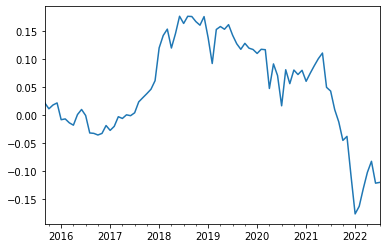

In [2]:
cfnv = pd.read_parquet(os.path.join(datadir, 'close_end_fund_net_value.par'))
cfnc = pd.read_parquet(os.path.join(datadir, 'close_end_fund_close_price.par'))
cefd = ((cfnv - cfnc) / cfnv).mean(axis=1)
cefd.name = 'CEFD'
cefd = cefd.resample('1M').last().ffill().dropna()
cefd.plot()

<AxesSubplot:>

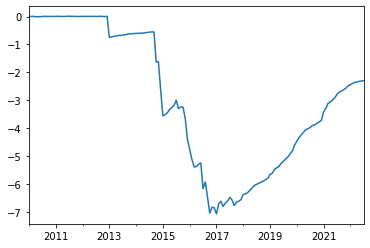

In [3]:
ofnv = pd.read_parquet(os.path.join(datadir, 'open_end_fund_net_value.par'))
ofnc = pd.read_parquet(os.path.join(datadir, 'open_end_fund_close_price.par'))
oefd = ((ofnv - ofnc) / ofnv).mean(axis=1)
oefd.name = 'OEFD'
oefd = oefd.resample('1M').last().ffill().dropna()
oefd.plot()

### $TURN_{t-1}$

Proxy for liquidity, CSI300 turnover ratio

- $log$ of CSI300 turnover ratio, then detrend it by one year moving average

- In a market with short-sales constraints, irrational investors participate, and thus add liquidity, only when they are optimistic; hence, high liquidity is a symptom of overvaluation (Baker&Stein, 2004)

- High turnover forecasts low market returns (Jones, 2001)

- Turnover displays an exponential, positive trend (Jones, 2001)

- Lag this indicator for one period

Data source: Wind Financial Terminal

#### Why lag?

- Some proxies may exhibit leadlag relationships, some may reflect a given shift in sentiment earlier than others (Baker&Wurgler, 2006)

- Baker&Wurgler(2006) did not explain why lag turnover, but they quote for some other lagged proxies

- IPO volume lags the first-day returns on IPOs. Perhaps sentiment is partly behind the high first-day returns, and this attracts additional IPO volume with a lag. (Ibbotson and Jaffe 1975, Lowry and Schwert 2002, Benveniste et al. 2003)

- More generally, proxies that involve firm supply responses ($S$ and $NIPO$ ) can be expected to lag behind proxies

<AxesSubplot:xlabel='date'>

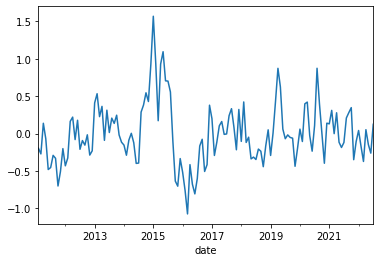

In [4]:
turn = np.log(pd.read_parquet(os.path.join(datadir, 'turnover.par')).iloc[:, 0])
turn.name = 'TURN'
turn = turn.resample('1M').last()
turn -= turn.rolling(12).mean()
turn = turn.shift(1).ffill().dropna()
turn.plot()

### $NIPO_t$ & $RIPO_{t-1}$

Number of IPOs during the last time span

Average return on the IPOs during the last time span

- The IPO market is often viewed as sensitive to sentiment, with high first-day returns on IPOs cited as a measure of investor enthusiasm, and the low idiosyncratic returns on IPOs often interpreted as a symptom of market timing (Stigler 1964, Ritter 1991)

- Lag $RIPO$ indicator for one period

Data source: Wind Financial Terminal

<AxesSubplot:xlabel='date'>

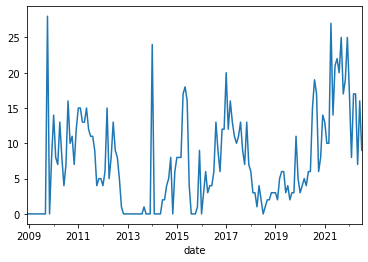

In [5]:
nipo = pd.read_parquet(os.path.join(datadir, 'nipo.par')).sum(axis=1).resample('M').sum()
nipo.name = 'NIPO'
nipo = nipo.resample('1M').last().ffill().dropna()
nipo.plot()

In [6]:
list_date = pd.read_parquet(os.path.join(datadir, 'list_date.par')).iloc[0,:].T
list_date = list_date[list_date > strat_date]
list_date = pd.MultiIndex.from_tuples(list(zip(list_date.index.values, list_date.values)))
list_date = pd.Series(True, index=list_date.swaplevel().sort_values())
list_date.index = pd.MultiIndex.from_arrays([list_date.index.get_level_values(0).to_period('M'), list_date.index.get_level_values(1)])

<AxesSubplot:xlabel='date'>

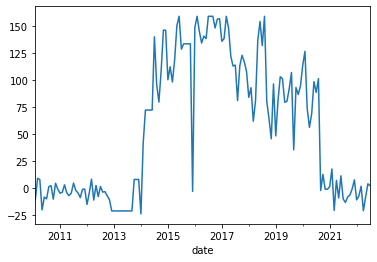

In [7]:
ripo = pd.read_parquet(os.path.join(datadir, 'ripo.par'))
ripo.name = 'RIPO'
ripo.index = pd.MultiIndex.from_arrays([ripo.index.get_level_values(0).to_period('M'), ripo.index.get_level_values(1)])
ripo = ripo.loc[ripo.index.intersection(list_date.index)].RIPO10.groupby('date').mean()
ripo.index = ripo.index.to_timestamp(how='e').normalize()
ripo = ripo.resample('1M').last()
ripo = ripo.shift(1).ffill().dropna()
ripo.plot()

### $S_t$

Equity financing proportion

- The share of equity issues in total equity and debt issues

- High values of the equity share predict low market returns (Baker&Wurgler, 2000)

- NOTE, there is no direct data for this, we use one-level difference of existing non-finance companys' data to proxy for the original

- And clearly not applicable

| code | unit | meaning | frequency | origin | source |
|:---:|:---:|:---:|:---:|:---:|:---:|
| M6422058 | $10^8$ ￥ | existing bond on liability of balance sheet of non-financial company | annual | 非金融企业总负债:债券 | 中国社会科学院 (CASS) |
| M6422059 | $10^8$ ￥ | existing equity on liability of balance sheet  of non-financial company | annual | 非金融企业总负债:股票及股权 | 中国社会科学院 (CASS) |


<AxesSubplot:>

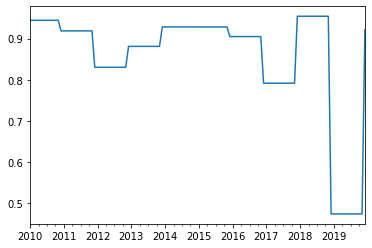

In [8]:
eqprop = pd.read_parquet(os.path.join(datadir, 'eqprop.par')).diff()
eqprop = eqprop['M6422059'] / (eqprop['M6422059'] + eqprop['M6422058'])
eqprop = eqprop.dropna().resample('1M').ffill()
eqprop = eqprop[eqprop.index > strat_date]
eqprop.name = 'EP' # denotes Equity Proportion
eqprop.plot()

### $P_{t-1}^{D-N D}$

Dividend premium

- The $\log$ difference of the average market-to-book ratios of dividend payers and nonpayers

- Relative investor demand for dividend-paying stocks (Baker&Wurgler, 2004)

- Given that payers are generally larger, more profitable firms with weaker growth opportunities (Fama&French, 2001)

- Lag this indicator for one period

Data source: Wind Financial Terminal

<AxesSubplot:>

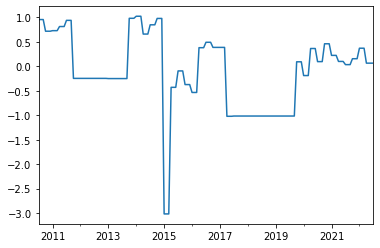

In [9]:
dividend = pd.read_parquet(os.path.join(datadir, 'dividend.par'))
pb_ratio = pd.read_parquet(os.path.join(datadir, 'pb_ratio.par'))
dividend_premium = pd.Series(map(lambda x: np.log(x) if x > 0 else -np.log(-x), \
    pb_ratio[dividend.isnull()].mean(axis=1) / \
    pb_ratio[~dividend.isnull()].mean(axis=1)),
    index = dividend.index)
dividend_premium = dividend_premium.resample('1M').last().ffill()
dividend_premium = dividend_premium.shift(1).dropna()
dividend_premium.name = 'DP' # denotes Dividend Premium
dividend_premium.plot()

### $SENTIMENT_t$

- Each sentiment proxy is likely to include a sentiment component as well as idiosyncratic, non-sentiment-related components (Baker&Wurgler, 2006)

- Use principal components analysis (aka. PCA) to isolate the common component

In [10]:
co_time = reduce(np.intersect1d, [cefd.index, turn.index, nipo.index, ripo.index, eqprop.index, dividend_premium.index])
# co_time = reduce(ba.intersect1d, [oefd.index, turn.index, nipo.index, ripo.index, eqprop.index, dividend_premium.index])
# co_time = reduce(ba.intersect1d, [turn.index, nipo.index, ripo.index, eqprop.index, dividend_premium.index])
# co_time = reduce(ba.intersect1d, [turn.index, nipo.index, ripo.index, dividend_premium.index])


cefd_copy = cefd.loc[co_time].copy()
# oefd = oefd.loc[co_time].copy()
turn_copy = turn.loc[co_time].copy()
nipo_copy = nipo.loc[co_time].copy()
ripo_copy = ripo.loc[co_time].copy()
eqprop_copy = eqprop.loc[co_time].copy()
dividend_premium_copy = dividend_premium.loc[co_time].copy()


In [11]:
sentiment = pd.concat([cefd_copy, turn_copy, nipo_copy, ripo_copy, eqprop_copy, dividend_premium_copy], axis=1)
# sentiment = ba.concat([oefd_copy, turn_copy, nipo_copy, ripo_copy, eqprop_copy, dividend_premium_copy], axis=1)
# sentiment = ba.concat([turn_copy, nipo_copy, ripo_copy, eqprop_copy, dividend_premium_copy], axis=1)
# sentiment = ba.concat([turn_copy, nipo_copy, ripo_copy, dividend_premium_copy], axis=1)


In [12]:
pc = PCA(sentiment, ncomp=sentiment.shape[1])
pc.eigenvals/pc.eigenvals.sum()
md(f'The principle component accounts for ${((pc.eigenvals/pc.eigenvals.sum())[0] * 100).round(3)}\%$ of total variation')

The principle component accounts for $45.309\%$ of total variation

In [13]:
coefs = pc.eigenvecs.iloc[:,0].round(3)
md('$SENTIMENT_t = ' + str(coefs[0]) +'CEFD_t ' + nstr(coefs[1]) + 'TURN_{t−1} ' \
    + nstr(coefs[2]) + 'NIPO_t ' + nstr(coefs[3]) + 'RIPO_{t−1} ' + nstr(coefs[4]) + 'S_t ' + nstr(coefs[5]) + 'P_{t-1}^{D−ND}$')

$SENTIMENT_t = 0.528CEFD_t +0.311TURN_{t−1} -0.262NIPO_t -0.456RIPO_{t−1} -0.331S_t -0.489P_{t-1}^{D−ND}$

<AxesSubplot:>

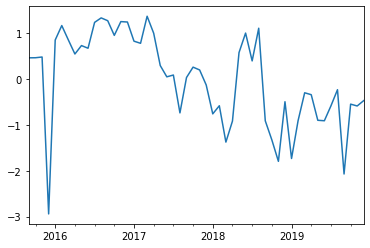

In [14]:
sentiment = pd.Series(sentiment.values @ pc.eigenvecs.iloc[:,0].values, index=sentiment.index)
sentiment = ((sentiment.mean() - sentiment)/sentiment.std())
sentiment.plot()

### Orthogonalize

- PCA cannot distinguish between a common sentiment component and a common business cycle component (Baker&Wurgler, 2006)

- For instance, the number of IPOs varies with the business cycle. We want to identify when the number of IPOs is high for no good reason.

- So we may want to construct an index to remove business cycle variation from each of the proxies prior to the principal components analysis.

- We regress on growth in consumer durables, nondurables, services, and unemployment rate.

In [15]:
marco = pd.read_parquet(os.path.join(datadir, 'marco.par'))
unemployment = pd.read_parquet(os.path.join(datadir, 'unemployment.par'))
marco_growth = marco.pct_change().resample('M').last().ffill().dropna()
unemployment_growth = unemployment.pct_change().resample('M').last().ffill().dropna()
orthgnlz_time = reduce(np.intersect1d , [marco_growth.index, unemployment_growth.index, cefd.index, turn.index, \
    nipo.index, ripo.index, eqprop.index, dividend_premium.index])

marco_growth = marco_growth.loc[orthgnlz_time].copy()
unemployment_growth = unemployment_growth.loc[orthgnlz_time].copy()

marco_growth = pd.concat([marco_growth, unemployment_growth], axis=1)
cefd_copy = cefd.loc[orthgnlz_time].copy()
# oefd_copy = oefd.loc[orthgnlz_time].copy()
turn_copy = turn.loc[orthgnlz_time].copy()
nipo_copy = nipo.loc[orthgnlz_time].copy()
ripo_copy = ripo.loc[orthgnlz_time].copy()
eqprop_copy = eqprop.loc[orthgnlz_time].copy()
dividend_premium_copy = dividend_premium.loc[orthgnlz_time].copy()

In [16]:
lr = LinearRegression()
cefd_orthgnlz = cefd_copy - lr.fit(marco_growth, cefd_copy).predict(marco_growth)
turn_orthgnlz = turn_copy - lr.fit(marco_growth, turn_copy).predict(marco_growth)
nipo_orthgnlz = nipo_copy - lr.fit(marco_growth, nipo_copy).predict(marco_growth)
ripo_orthgnlz = ripo_copy - lr.fit(marco_growth, ripo_copy).predict(marco_growth)
eqprop_orthgnlz = eqprop_copy - lr.fit(marco_growth, eqprop_copy).predict(marco_growth)
dividend_premium_orthgnlz = dividend_premium_copy - lr.fit(marco_growth, dividend_premium_copy).predict(marco_growth)


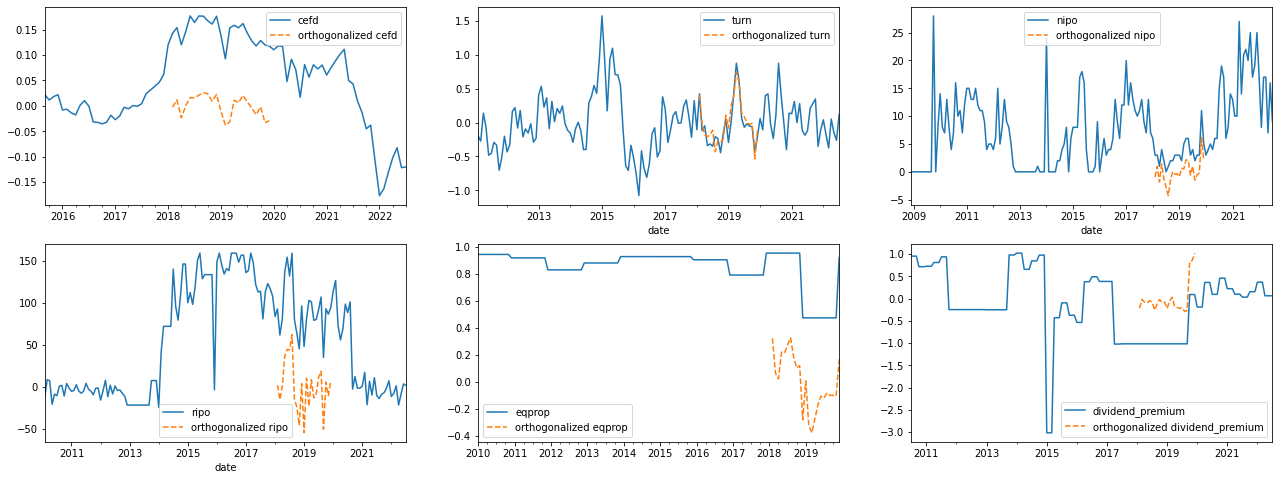

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22,8))
cefd.plot(label='cefd', ax=axes[0,0])
cefd_orthgnlz.plot(linestyle='--', label='orthogonalized cefd', ax=axes[0,0])
axes[0,0].legend()
turn.plot(label='turn', ax=axes[0,1])
turn_orthgnlz.plot(linestyle='--', label='orthogonalized turn', ax=axes[0,1])
axes[0,1].legend()
nipo.plot(label='nipo', ax=axes[0,2])
nipo_orthgnlz.plot(linestyle='--', label='orthogonalized nipo', ax=axes[0,2])
axes[0,2].legend()
ripo.plot(label='ripo', ax=axes[1,0])
ripo_orthgnlz.plot(linestyle='--', label='orthogonalized ripo', ax=axes[1,0])
axes[1,0].legend()
eqprop.plot(label='eqprop', ax=axes[1,1])
eqprop_orthgnlz.plot(linestyle='--', label='orthogonalized eqprop', ax=axes[1,1])
axes[1,1].legend()
dividend_premium.plot(label='dividend_premium', ax=axes[1,2])
dividend_premium_orthgnlz.plot(linestyle='--', label='orthogonalized dividend_premium', ax=axes[1,2])
axes[1,2].legend()


In [18]:
sentiment_orthgnlz = pd.concat([cefd_orthgnlz, turn_orthgnlz, nipo_orthgnlz, ripo_orthgnlz, eqprop_orthgnlz, dividend_premium_orthgnlz], axis=1)
pc_orthgnlz = PCA(sentiment_orthgnlz, ncomp=sentiment_orthgnlz.shape[1])
pc_orthgnlz.eigenvals/pc_orthgnlz.eigenvals.sum()
md(f'The principle component accounts for ${((pc_orthgnlz.eigenvals/pc_orthgnlz.eigenvals.sum())[0] * 100).round(3)}\%$ of total variation')

The principle component accounts for $39.037\%$ of total variation

In [19]:
coefs_orthgnlz = pc_orthgnlz.eigenvecs.iloc[:,0].round(3)
md('$SENTIMENT_t^⊥ = ' + str(coefs_orthgnlz[0]) +'CEFD_t^⊥ ' + nstr(coefs_orthgnlz[1]) + 'TURN_{t−1}^⊥ ' \
    + nstr(coefs_orthgnlz[2]) + 'NIPO_t^⊥ ' + nstr(coefs_orthgnlz[3]) + 'RIPO_{t−1}^⊥ ' + nstr(coefs_orthgnlz[4]) + 'S_t^⊥ ' + nstr(coefs_orthgnlz[5]) + 'P_{t-1}^{D−ND,⊥}$')

$SENTIMENT_t^⊥ = 0.47CEFD_t^⊥ -0.237TURN_{t−1}^⊥ -0.528NIPO_t^⊥ +0.33RIPO_{t−1}^⊥ +0.485S_t^⊥ -0.317P_{t-1}^{D−ND,⊥}$

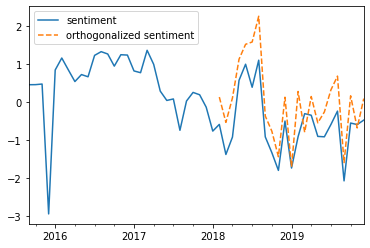

In [20]:
sentiment_orthgnlz = pd.Series(sentiment_orthgnlz.values @ pc_orthgnlz.eigenvecs.iloc[:,0].values, index=sentiment_orthgnlz.index)
sentiment_orthgnlz = ((sentiment_orthgnlz - sentiment_orthgnlz.mean())/sentiment_orthgnlz.std())
sentiment.plot(label='sentiment')
sentiment_orthgnlz.plot(linestyle='--', label='orthogonalized sentiment')
plt.legend()

## Part II. Empirical Tests

In [21]:
pb_ratio = pd.read_parquet(os.path.join(datadir, 'pb_ratio.par')).resample('M').last().ffill().dropna(axis=1)
equity = pd.read_parquet(os.path.join(datadir, 'equity.par')).resample('M').last().ffill().dropna(axis=1)
ebitda = pd.read_parquet(os.path.join(datadir, 'ebitda.par')).resample('M').last().ffill().dropna(axis=1)
close = pd.read_parquet(os.path.join(datadir, 'close.par')).resample('M').last().ffill().dropna(axis=1)
ret = close.pct_change().dropna()
mkt_value = pd.read_parquet(os.path.join(datadir, 'mkt_value.par')).resample('M').last().ffill().dropna(axis=1)
dividend = pd.read_parquet(os.path.join(datadir, 'dividend.par')).resample('M').last().ffill().dropna(axis=1)
found_date = pd.read_parquet(os.path.join(datadir, 'found_date.par')).resample('M').last().ffill().dropna(axis=1)

co_stocks = reduce(np.intersect1d, [pb_ratio.columns, equity.columns, ebitda.columns, close.columns, mkt_value.columns, dividend.columns, found_date.columns])
co_time = reduce(np.intersect1d, [co_time, pb_ratio.index, equity.index, ebitda.index, close.index, mkt_value.index, dividend.index, found_date.index])
pb_ratio = pb_ratio.loc[co_time, co_stocks]
equity = equity.loc[co_time, co_stocks]
ebitda = ebitda.loc[co_time, co_stocks]
close = close.loc[co_time, co_stocks]
mkt_value = mkt_value.loc[co_time, co_stocks]
dividend = dividend.loc[co_time, co_stocks]
found_date = found_date.loc[co_time, co_stocks]

In [22]:
found_date = found_date.iloc[0,:].apply(lambda x: (dt('2022-7-21') - x).days)
found_date.name = 'found_days'
found_days = found_date

In [23]:
def get_certain_rank_mean_return(rank_frame, rank):

    certain_rank_stocks = rank_frame.apply(lambda row: get_certain_rank_stocks(row, rank), axis=1)
    certain_rank_return = ret.loc[ret.index.intersection(certain_rank_stocks.index)].apply(lambda row: \
        row.loc[certain_rank_stocks.loc[row.name]].mean(), axis=1)
    certain_rank_average_return_over_month = certain_rank_return.mean()

    return certain_rank_average_return_over_month

In [24]:
def sort_return_with_sentiment(characteristic, total_bins):

    rank_frame = characteristic.apply(lambda row: pd.qcut(row, total_bins, labels=False).sort_values(), axis=1)

    lagged_sentiment = sentiment_orthgnlz.shift(1).dropna()
    positive_sentiment_rank_frame = rank_frame.loc[rank_frame.index.intersection(lagged_sentiment[lagged_sentiment > 0].index)]
    negative_sentiment_rank_frame = rank_frame.loc[rank_frame.index.intersection(lagged_sentiment[lagged_sentiment < 0].index)]

    positive_sentiment_ranked_value = pd.Series(np.nan, index=range(total_bins))
    negative_sentiment_ranked_value = pd.Series(np.nan, index=range(total_bins))

    for certain_rank in range(total_bins):
        positive_sentiment_ranked_value[certain_rank] = get_certain_rank_mean_return(positive_sentiment_rank_frame, certain_rank)
        negative_sentiment_ranked_value[certain_rank] = get_certain_rank_mean_return(negative_sentiment_rank_frame, certain_rank)

    return positive_sentiment_ranked_value, negative_sentiment_ranked_value, [ret.index.intersection(lagged_sentiment.index)[0], ret.index.intersection(lagged_sentiment.index)[1]]


def sort_return_with_sentiment_for_series(characteristic, total_bins):
    rank_series = pd.qcut(characteristic, total_bins, labels=False).sort_values()

    lagged_sentiment = sentiment_orthgnlz.shift(1).dropna()
    positive_sentiment_period = lagged_sentiment[lagged_sentiment > 0].index
    negative_sentiment_period = lagged_sentiment[lagged_sentiment < 0].index
    positive_sentiment_ranked_value = pd.Series(np.nan, index=range(total_bins))
    negative_sentiment_ranked_value = pd.Series(np.nan, index=range(total_bins))

    for rank in range(total_bins):
        stocks = rank_series[rank_series == rank].index
        positive_sentiment_ranked_value[rank] = ret.loc[positive_sentiment_period, stocks].mean(axis=1).mean()
        negative_sentiment_ranked_value[rank] = ret.loc[negative_sentiment_period, stocks].mean(axis=1).mean()
        

    return positive_sentiment_ranked_value, negative_sentiment_ranked_value, [ret.index.intersection(lagged_sentiment.index)[0], ret.index.intersection(lagged_sentiment.index)[1]]

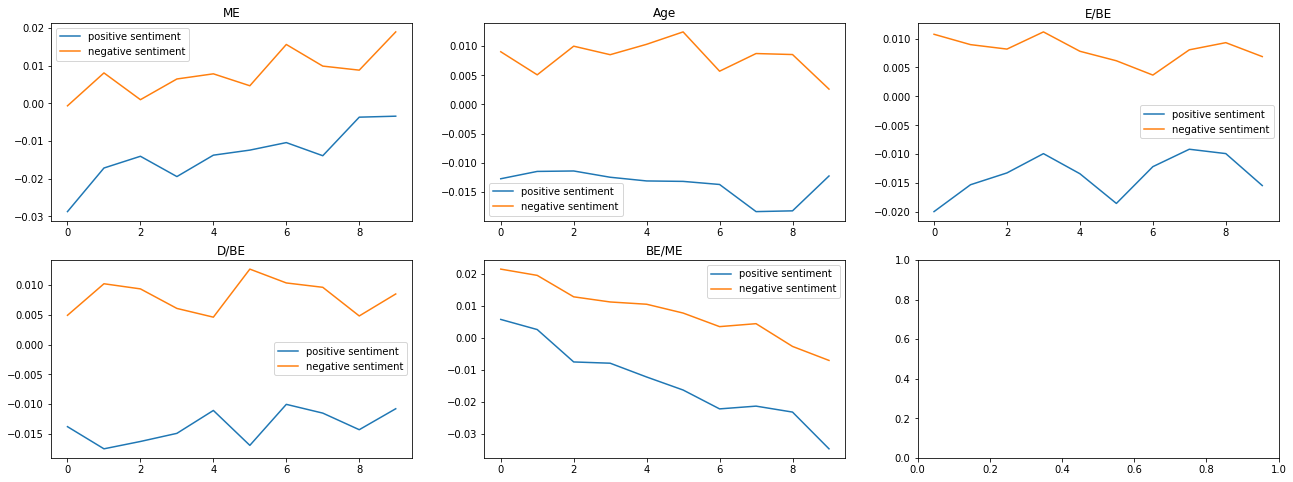

In [25]:
# NOTE, some characteristics not used (lack of data)

# 25-days' σ
# PPE/A
# RD/A
# EF/A
# GS

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22,8))
ME = sort_return_with_sentiment(mkt_value, 10)
ME[0].plot(label='positive sentiment', ax=axes[0,0])
ME[1].plot(label='negative sentiment', ax=axes[0,0])
# display(md(f'$ME$ calculated from {ME[2][0].strftime("%Y-%m-%d")} to {ME[2][1].strftime("%Y-%m-%d")}'))
axes[0,0].set_title('ME')
axes[0,0].legend()
Age = sort_return_with_sentiment_for_series(found_days, 10)
Age[0].plot(label='positive sentiment', ax=axes[0,1])
Age[1].plot(label='negative sentiment', ax=axes[0,1])
# display(md(f'$Age$ calculated from {Age[2][0].strftime("%Y-%m-%d")} to {Age[2][1].strftime("%Y-%m-%d")}'))
axes[0,1].set_title('Age')
axes[0,1].legend()
EBE = sort_return_with_sentiment(ebitda/equity, 10)
EBE[0].plot(label='positive sentiment', ax=axes[0,2])
EBE[1].plot(label='negative sentiment', ax=axes[0,2])
# display(md(f'$E/BE$ calculated from {EBE[2][0].strftime("%Y-%m-%d")} to {EBE[2][1].strftime("%Y-%m-%d")}'))
axes[0,2].set_title('E/BE')
axes[0,2].legend()
DBE = sort_return_with_sentiment(dividend/equity, 10)
DBE[0].plot(label='positive sentiment', ax=axes[1,0])
DBE[1].plot(label='negative sentiment', ax=axes[1,0])
# display(md(f'$D/BE$ calculated from {DBE[2][0].strftime("%Y-%m-%d")} to {DBE[2][1].strftime("%Y-%m-%d")}'))
axes[1,0].set_title('D/BE')
axes[1,0].legend()
BEME = sort_return_with_sentiment(1/pb_ratio, 10)
BEME[0].plot(label='positive sentiment', ax=axes[1,1])
BEME[1].plot(label='negative sentiment', ax=axes[1,1])
# display(md(f'$BE/ME$ calculated from {BEME[2][0].strftime("%Y-%m-%d")} to {BEME[2][1].strftime("%Y-%m-%d")}'))
axes[1,1].set_title('BE/ME')
axes[1,1].legend()

Clearly, sentiment works.

- the calculation time span is short (only 2018+), firm characteristics are insufficient

- **the previous month's negative sentiment indicates the next month's positive overall return, vice versa**

> when beginning-of-period proxies for sentiment are low, subsequent returns are relatively high

- **but, conclusions on $ME$ and $BE/ME$ are different from most paper.** Here the firm characteristic data preprocessing precedure is simple (drop NA), resulting in data selection bias. Only 887 stocks used (total 4000+), and they are predominantly blue chip stocks.

The main idea of this notebook is to confirm whether the sentiment proxy and its priciple component are valid.

And they are good. So we skip the portfolio analysis part, control variable part, and abnormal return after earnings announcement part. You're welcome to complete them.